# Kaggle Challaenge - Predict CO2 Emissions in Rwanda

## Overview

This is a challenge held by kaggle at August 1, 2023 and completed in August 21, 2023. I know I am late to this competition but I am sure this will be a fun challenge for me too. The challenge is from the Kaggle Playground Series - Season 3, Episode 20.

**Objective** - The objective of this challenge is to create machine learning models that use open-source emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

Approximately 497 unique locations were selected from multiple areas in Rwanda, with a distribution around farm lands, cities and power plants. The data for this competition is split by time; the years 2019 - 2021 are included in the training data, and the task is to predict the CO2 emissions data for 2022 through November.

Seven main features were extracted weekly from Sentinel-5P from January 2019 to November 2022. Each feature (Sulphur Dioxide, Carbon Monoxide, etc) contain sub features such as column_number_density which is the vertical column density at ground level, calculated using the DOAS technique.

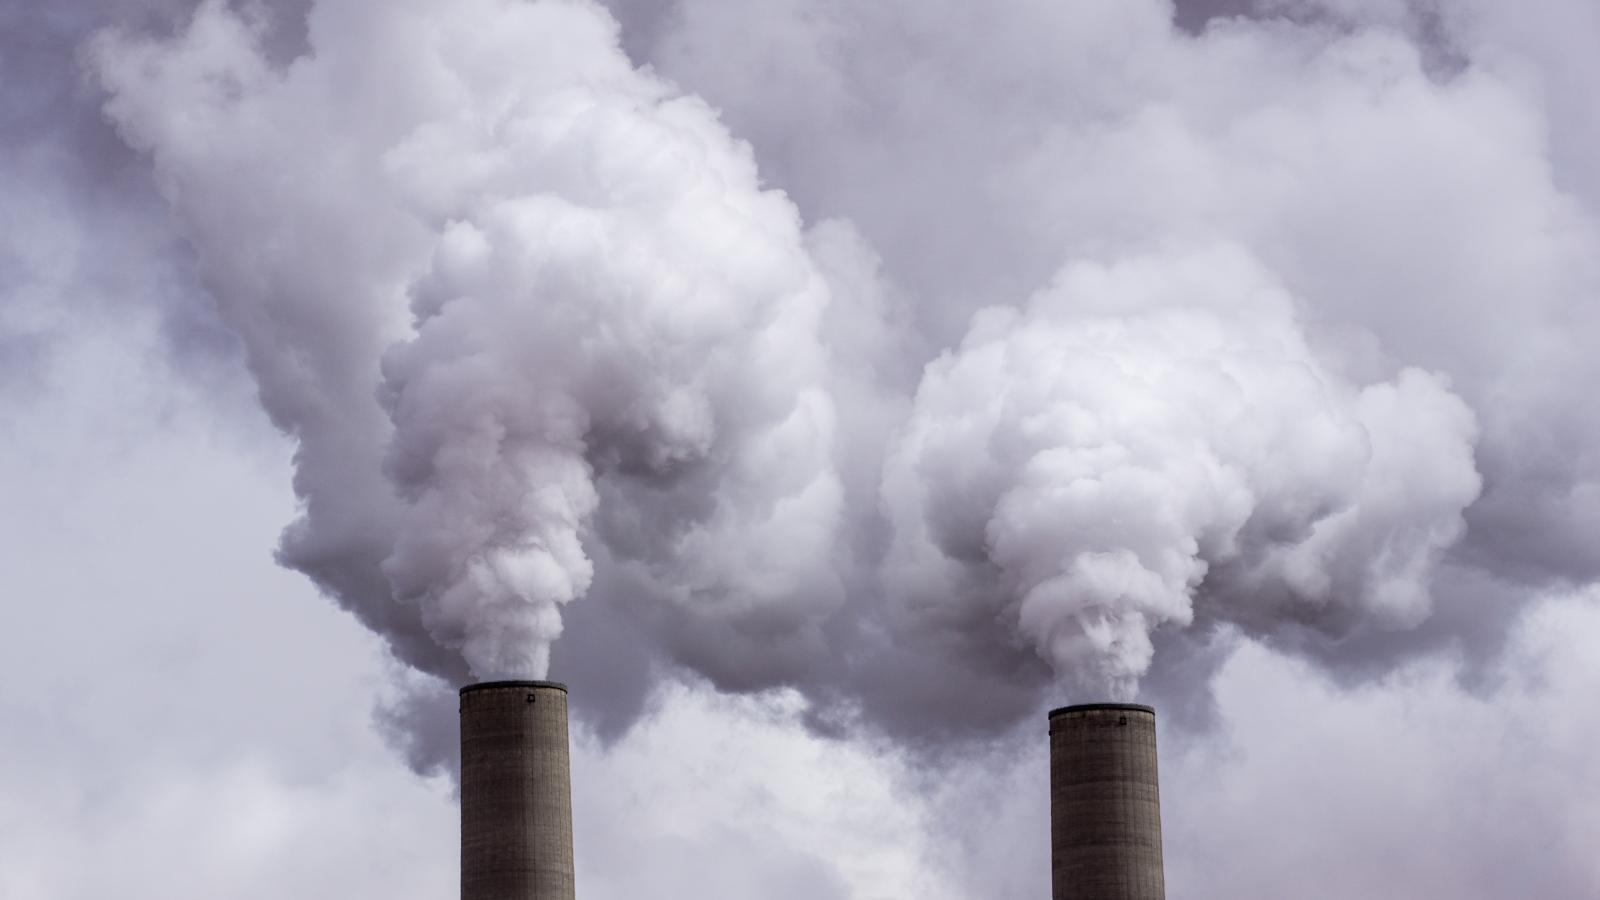

# Steps taken for this challenege

The steps that will be taken are written below:
1. Exploring the dataset on the high-level
2. Handling Missing & Duplicate Data
3. Handling Outliers
4. Thorough EDA (on low-level)
5. Feature Engineering
6. Preprocessing
7. Model Selection and implementation
8. Hyperparameter tuning
9. Submission

## 1. Exploring the dataset on the high-level

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
import matplotlib

from sklearn.cluster import KMeans

# Random state
SEED = 42

from haversine import haversine

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

In [2]:
# exploring the dataset
df = pd.read_csv(r'C:\MY FILES\Kaggle\co2_emission\train.csv')
df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [3]:
# getting all the column names
df_columns = df.columns
df_columns

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide

The data consists of seven main features, and within each ones there are several sub-features. In order to get the domain knowledge, we need to dig in. I know it can be tiring, but after we have finished going through, it will be easy for us.

As I have mentioned, the dataset is distributed into seven main features, and they are:

1. `SulphurDioxide_SO2`
2. `CarbonMonoxide_CO`
3. `NitrogenDioxide_NO2`
4. `Formaldehyde`
5. `UvAerosolIndex`
6. `Ozone_O3`
7. `Cloud`

And the sub-features which come under are:

1. `column_number_density`
2. `column_number_density_amf`
3. `slant_column_number_density`
4. `cloud_fraction`
5. `sensor_azimuth_angle`
6. `sensor_zenith_angle`
7. `solar_azimuth_angle`
8. `solar_zenith_angle`
9. `column_number_density_15km`

Except these we have `latitude`, `longitude`, `year`, `week_no`, `ID_LAT_LON_YEAR_WEEK`, and `emission`. We have to predict `emission` for this project.

After getting the gist of the dataset, let's dig deep into the sub-features.

1. **column_number_density**: It is the vertical column density at ground level.
2. **slant_column_number_density**: It is the ring corrected slant column number density.
3. **column_number_density_amf**: It is the weighted mean of cloudy and clear air mass factor (amf).
4. **cloud_fraction**: It is the percentage of each pixel in satellite imagery.
5. **sensor_azimuth_angle**: It is the azimuth angle of the satellite at the ground pixel location; angle measured East-of-North
6. **sensor_zenith_angle**: It is the zenith angle of the satellite at the ground pixel location; angle measured away from the vertical.
7. **solar_azimuth_angle**: It is the azimuth angle of the Sun at the ground pixel location; angle measured East-of-North.
8. **solar_zenith_angle**: It is the zenith angle of the satellite at the ground pixel location; angle measured away from the vertical.
9. **column_number_density_15km**: It is the vertical column density at 15km.

In [4]:
# basic info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

There are lots of missing values in the dataset, specially `UvAerosolLayerHeight` group. We have to deal with this group in the future. Furthermore, the type of `year` column may need to be changed.

In [5]:
# statistical summary of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,79023.0,-1.891072,0.694522,-3.299000,-2.451000,-1.882000,-1.303000,-0.510000
longitude,79023.0,29.880155,0.810375,28.228000,29.262000,29.883000,30.471000,31.532000
year,79023.0,2020.000000,0.816502,2019.000000,2019.000000,2020.000000,2021.000000,2021.000000
week_no,79023.0,26.000000,15.297155,0.000000,13.000000,26.000000,39.000000,52.000000
SulphurDioxide_SO2_column_number_density,64414.0,0.000048,0.000272,-0.000996,-0.000096,0.000024,0.000153,0.004191
...,...,...,...,...,...,...,...,...
Cloud_sensor_azimuth_angle,78539.0,-10.784832,30.374462,-102.739731,-30.309170,-12.673914,9.402202,78.223037
Cloud_sensor_zenith_angle,78539.0,40.436976,6.428216,2.998873,35.829907,41.119630,44.446272,65.951248
Cloud_solar_azimuth_angle,78539.0,-86.800583,37.837269,-153.464211,-125.991158,-84.644352,-48.132701,-22.653170
Cloud_solar_zenith_angle,78539.0,27.925981,4.403835,10.818288,24.686763,28.333630,31.499883,42.060436


From the above statistical summary, we can deduce some of the following insights:

* The train data provided ranges from year 2019 to 2021
* Minimum recorded emissions ranges from 0.(may have resulted from missing values) to maximum of 3167.76800
* Week of the year starts from 0 to 52
* The latitude and longitudes ranges show that the regions are mostly within Rwanda

## 2. Handling Missing & Duplicate Data

As we have seen that we have the most missing values in the `UvAerosol` domain, other domains such as `CO2`, `CO` etc. has significant missing values. Here is a graphical representation:

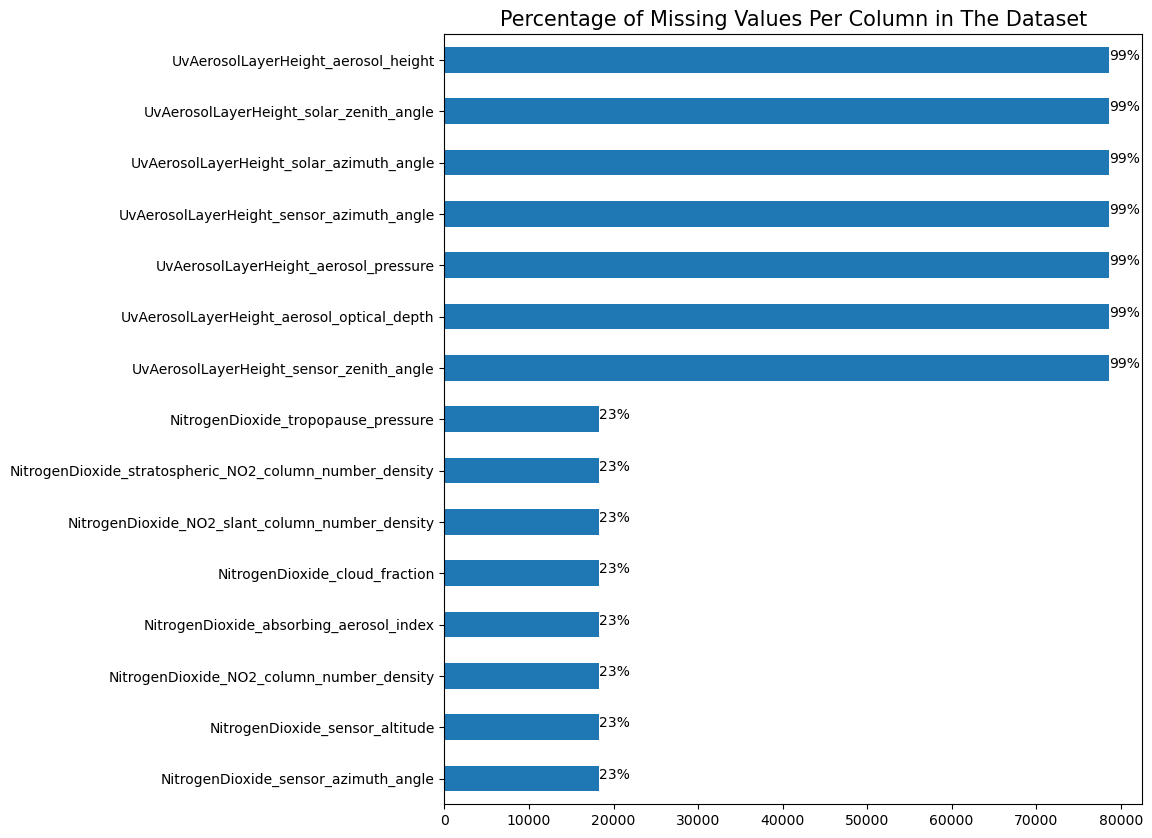

In [6]:
# plotting missing values in train set
ax = df.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in The Dataset', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/df.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

According to the bar chart above, the "UvAerosolLayerHeight" gas has the least number of entrys (less than 500) which constitutes less than 1% of the entire dataset. We can remove all the rows pertaining "UvAerosolLayerHeight" because it won't harm the result at the end. 

In [7]:
uv_aerosol_cols = ['UvAerosolLayerHeight_aerosol_height', 'UvAerosolLayerHeight_aerosol_pressure',
                   'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle',
                   'UvAerosolLayerHeight_sensor_azimuth_angle', 'UvAerosolLayerHeight_solar_azimuth_angle',
                   'UvAerosolLayerHeight_solar_zenith_angle']
df.drop(columns=uv_aerosol_cols, inplace=True) 

In [8]:
# remaining no. of columns
len(df.columns)

69

As we know that our prediction variable is `emission`, it is very important to explore it before going forward. Let's explore it and try to find out if something strange occurs.

In [9]:
# checking missing values
sum(df['emission'].isnull())

0

In [10]:
# checking duplicate rows
subset = list(df.columns)[5:]
duplicate_emissions = df[df.duplicated(subset = subset, keep=False)]

num_duplicates = duplicate_emissions.shape[0]
print(f"\nNumber of Duplicate Rows: {num_duplicates}")


Number of Duplicate Rows: 0


It looks like there are no duplicate rows in the dataset.

In [11]:
# imputing the dataset
df.fillna(df.mean(), inplace=True)

C:\Users\amins\AppData\Local\Temp\ipykernel_1012\2325778179.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


In [12]:
display(df.isna().sum().sort_values())

ID_LAT_LON_YEAR_WEEK                                       0
Formaldehyde_HCHO_slant_column_number_density              0
Formaldehyde_cloud_fraction                                0
Formaldehyde_solar_zenith_angle                            0
Formaldehyde_solar_azimuth_angle                           0
                                                          ..
CarbonMonoxide_solar_azimuth_angle                         0
CarbonMonoxide_sensor_zenith_angle                         0
CarbonMonoxide_sensor_azimuth_angle                        0
NitrogenDioxide_stratospheric_NO2_column_number_density    0
emission                                                   0
Length: 69, dtype: int64

## 3. Handling Outliers

Outlier handling is very important in prediction, especially in regression model. We can check for outliers from every features. But it will be time consuming and the notebook will be huge. We will only see about the `emission` variable. But if it is needed we may change the numerical values into logarithmic scale in order to mitigate the effects of the outliers. 

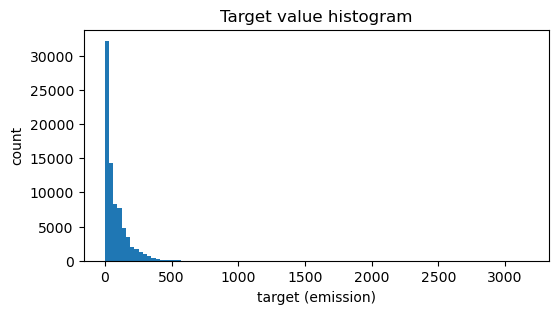

In [13]:
# distribution of the target variable
plt.figure(figsize=(6, 3))
plt.hist(df.emission, bins=100)
plt.title('Target value histogram')
plt.xlabel('target (emission)')
plt.ylabel('count')
plt.show()

As we can see that the plot is right-skewed. It is understandable that we may want to use different methods such as log transform, box-cox transform or square root transform. But as this competition will score it using RMSE, the usual target transformations make it very hard to optimize for RMSE. We may use these methods in the future in order to compare the scores.

C:\Users\amins\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


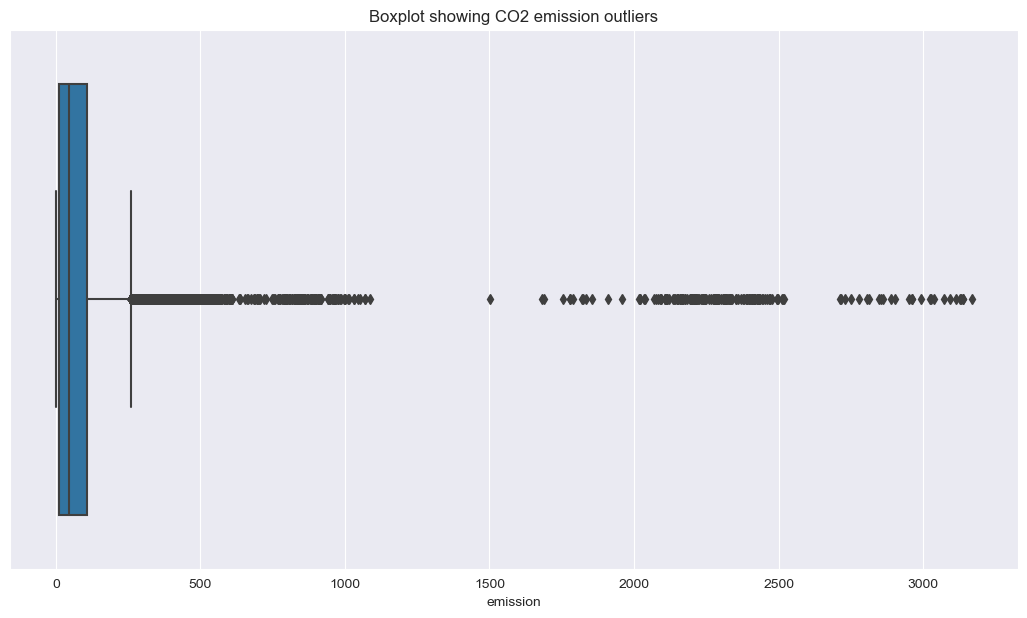

In [14]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(df.emission)
plt.title('Boxplot showing CO2 emission outliers')  
plt.show()

After viewing the box plot one can understand that all the emission value more than 2500 could be outliers. Let's look at those values in terms of location and time.

In [15]:
# viewing all the rows with emission > 2600
df[['latitude', 'longitude', 'year', 'week_no', 'emission']][df.emission > 2600]

,latitude,longitude,year,week_no,emission
46587,-2.079,29.321,2019,0,2778.1920
46588,-2.079,29.321,2019,1,2950.9507
46589,-2.079,29.321,2019,2,3093.1740
46590,-2.079,29.321,2019,3,3136.0488
46591,-2.079,29.321,2019,4,3131.8489
46592,-2.079,29.321,2019,5,3167.7680
46593,-2.079,29.321,2019,6,3112.7644
46594,-2.079,29.321,2019,7,3128.4414
46595,-2.079,29.321,2019,8,3136.6560
46640,-2.079,29.321,2020,0,2710.7104


After carefully looking at the values, these values were taken on the same location (-2.079, 29.321) and we can see a pattern for all three years. In each week coming, the values starts to increase and usually crosses the 3000 threshold. Therefore, I believe that we should not consider these values to be outliers. Maybe that location has excessive amount of emission.

## 4. Thorough EDA (on low-level)

As far as now we were doing a high-level overview of the dataset. But I think we need to go deeper so that our understanding of the target variable and non-target varibales and also their rerlationship get more accurate. Let's dive in now.

Previously we saw the emission histogram which let us knew that the distribution is right-skewed. Let's think differently now. Let's see how the graph looks like in terms of emission per location.

In [16]:
# grouping all the values in term of locations
df.groupby(['latitude', 'longitude']).emission.mean().sort_values()

latitude  longitude
-1.682    29.218          0.000000
-2.859    29.041          0.000000
-1.833    28.467          0.000000
-2.841    29.159          0.000000
-1.974    28.526          0.000000
                          ...     
-1.342    31.358        409.606870
-0.956    30.744        455.398039
-1.346    31.254        475.289138
-2.079    29.321       1221.886518
-2.378    29.222       2233.431628
Name: emission, Length: 497, dtype: float64

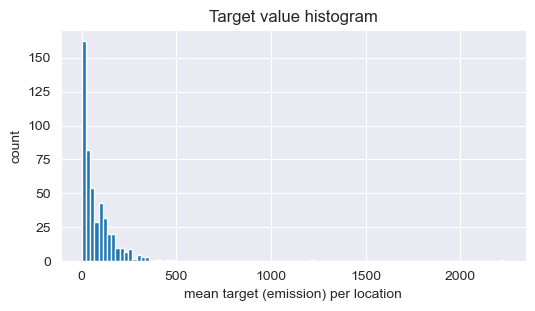

In [17]:
plt.figure(figsize=(6, 3))
plt.hist(df.groupby(['latitude', 'longitude']).emission.mean(), bins=100)
plt.title('Target value histogram')
plt.xlabel('mean target (emission) per location')
plt.ylabel('count')
plt.show()

It is expected that even if we group the values by location the distribution is righ-skewed. This doesn't mean anything more than what I have mentioned before.

After grouping all the values by location an interesting thing caught my eye. There are several locations where the emission is always zero.

In [18]:
# viweing locations that has zero emissions
df.groupby(['latitude', 'longitude']).emission.mean().sort_values()[:15]

latitude  longitude
-1.682    29.218       0.0
-2.859    29.041       0.0
-1.833    28.467       0.0
-2.841    29.159       0.0
-1.974    28.526       0.0
-1.730    28.470       0.0
-1.712    28.688       0.0
-1.696    28.304       0.0
-2.817    29.283       0.0
-1.839    28.761       0.0
-2.496    28.504       0.0
-2.898    29.002       0.0
-1.532    28.568       0.0
-1.505    30.995       0.0
-1.328    28.872       0.0
Name: emission, dtype: float64

Apparently, there are fifteen locations where the emission is zero. It is safe to assume that the values are so near zero that they are written as zeros. Additionally, in theory it is possible for a specific location to have zero carbon emissions, especially if the activities in that location do not involve the combustion of fossil fuels or other processes that release carbon dioxide (CO2) into the atmosphere.

Now, to understand better I am going to plot the data in geological coordinates.

In [19]:
def rgba_to_hex(color):
    """Return color as #rrggbb for the given color values."""
    red, green, blue, alpha = color
    return f"#{int(red*255):02x}{int(green*255):02x}{int(blue*255):02x}"

temp = df.groupby(['latitude', 'longitude']).emission.mean().reset_index()
geometry = gpd.points_from_xy(temp.longitude, temp.latitude)

cmap = matplotlib.colormaps['coolwarm']
normalizer = matplotlib.colors.Normalize(vmin=np.log1p(temp.emission.min()), vmax=np.log1p(temp.emission.max()))

# Creating a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Creating a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geometry]

# Iterating through list and adding a marker for each location
for coordinates, emission in zip(geo_df_list, temp.emission):
#     print(emission, normalizer(emission), rgba_to_hex(cmap(normalizer(emission))))
    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            color = rgba_to_hex(cmap(normalizer(np.log1p(emission))))),
        )
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

The emissions are color-coded as `dark-blue = high emission`; `green = low emission`. We see that the emissions are clustered:

* Points in the west (Democratic Republic of the Congo) all have low emissions.
* The two red points with the highest emissions are both near Lac Kivu.

This is an interesting find. Let's investigate this further.

<AxesSubplot:title={'center':'Top 20 emissions by location'}>

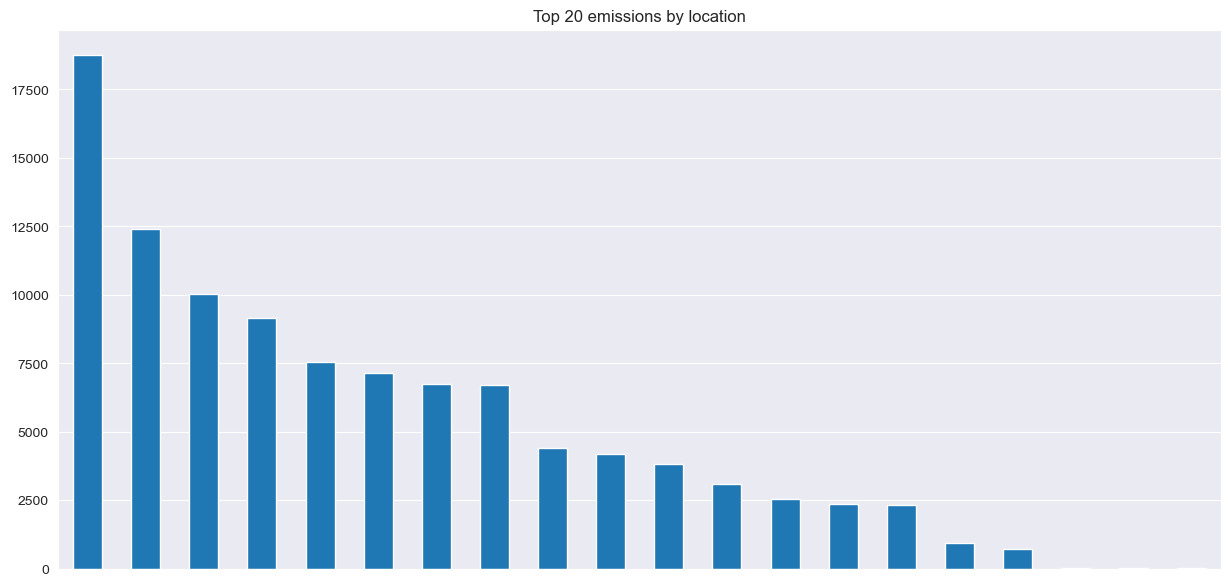

In [20]:
grouped = df.groupby(['latitude', 'longitude'])['emission'].sum().reset_index()
grouped["emission"][:20].sort_values(ascending = False).plot(kind = 'bar', title = 'Top 20 emissions by location',
                                                        xticks = [], figsize=(15, 7))

Indeed, there are two locations that are the highest in CO2 emission (more than 10000). Now, let's look at the emission by date. First we need to create a date column, then group all the rows by those dates and plot them.

In [21]:
# creating date column
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['week_no'].astype(str) + '-1', format='%Y-%W-%w')

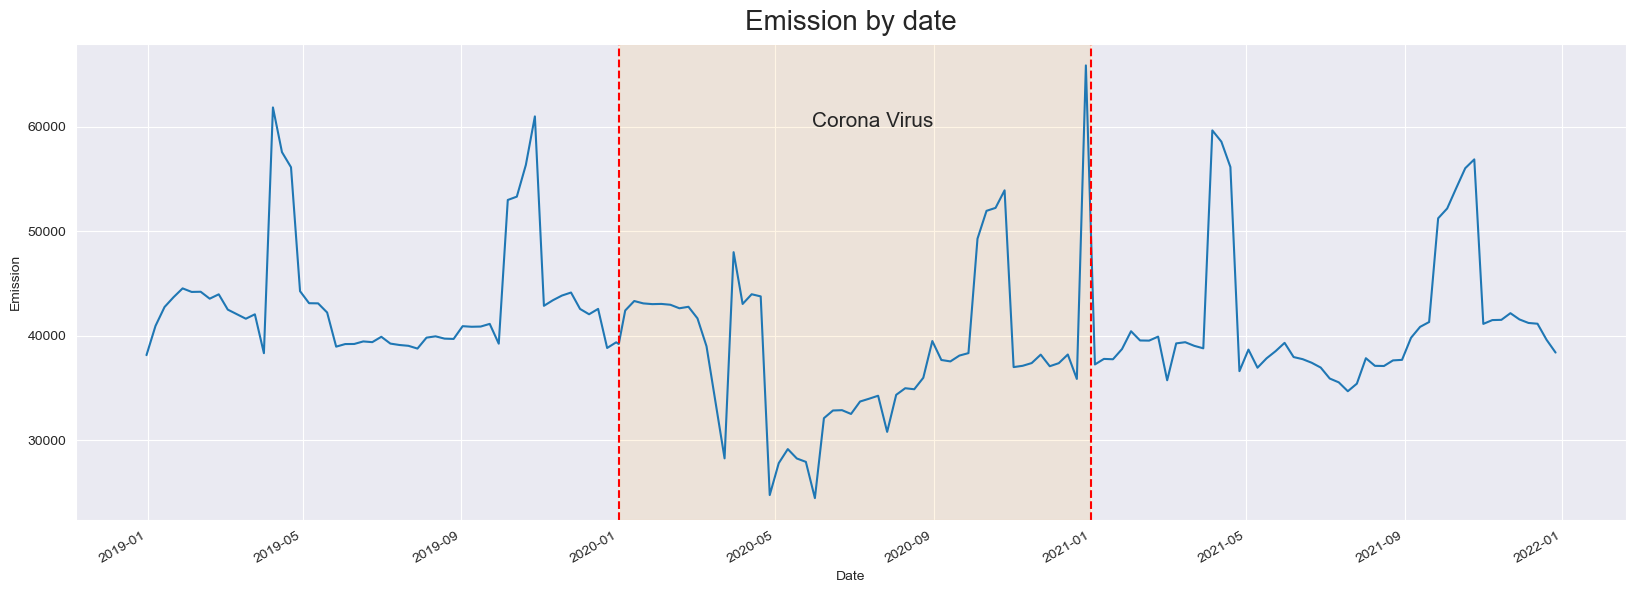

In [22]:
# plotting emission by date
df.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date', ylabel='Emission')

plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='orange', alpha=0.1)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='red')
plt.axvline(pd.Timestamp('2021-01-01'), linestyle = "--", color='red')

plt.text(pd.Timestamp ('2020-05-30'), 60000, "Corona Virus", size = 15)

plt.title('Emission by date', size=20, pad=10)
plt.show()

The figure above displays the CO2 emission by date. We can see that the second quarter of the year 2020 shows some weird pattern which is not similar with 2019 and 2021. Presumably this pattern occured due to corona outbreak over the year 2020. We should deal with it later because it may introduce overfitting in our model.

We should also see seasonal trends and behavior because we might get valuable insight from those patterns.

In [23]:
# dataframe without rows pertaining year 2020
df_no_2020 = df[df['date'].dt.year != 2020]

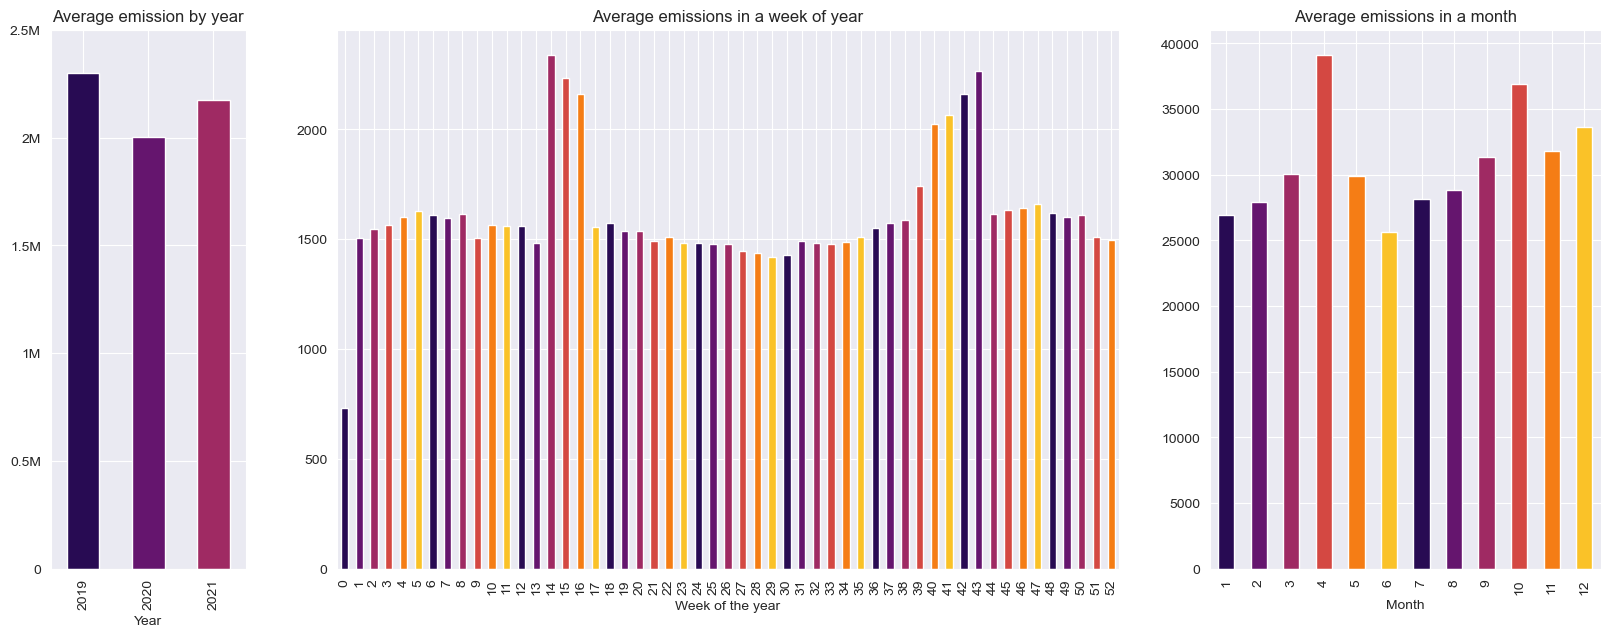

In [24]:
# showing patterns for all the dates except 2020
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 4, 2]}, figsize=(20,7))

df.groupby('year')['emission'].sum().plot(kind='bar', title='Average emission by year', xlabel='Year', color=sns.color_palette('inferno'), ax=axs[0])

avg_week = df_no_2020.groupby('week_no')['emission'].sum() / 52
avg_week.plot(kind='bar', title='Average emissions in a week of year', xlabel='Week of the year', color=sns.color_palette('inferno'), ax=axs[1])

avg_month = df_no_2020.groupby(df['date'].dt.month)['emission'].sum() / 12
avg_month.plot(kind='bar', title='Average emissions in a month', xlabel='Month', color=sns.color_palette('inferno'), ax=axs[2])

axs[0].set_xticklabels([2019, 2020, 2021])
axs[0].set_yticks(list(range(0, 3000000, 500000)), ['0', '0.5M', '1M', '1.5M', '2M', '2.5M'])

plt.show()

We can see that in year 2020 because of the epidemic there is sudden drop in emission (average per year). Moreover, from the perspective of weeks and months noticeable patterns can be seen. In the week number 14 to 16 the emission significantly increased. Same as for the week number 39 to 43. Additionally, the average emission throughout the year has minimal fluctuation except month no 5 and 10 or May and October.

## 5. Feature Engineering

In this section we will try to find out which features from the dataset are important for our prediction. It is very crucial to decide that because only important features can determine the best possible score. After finding out the right features, we may have to create new features to add in the dataset hoping to increase the prediction score. Let's start.

In [25]:
# Top 20 correlated features to the target
top20_corrs = abs(df.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                    1.000000
longitude                                                   0.102746
Cloud_surface_albedo                                        0.046530
CarbonMonoxide_H2O_column_number_density                    0.042635
CarbonMonoxide_CO_column_number_density                     0.040772
Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.037577
Formaldehyde_tropospheric_HCHO_column_number_density        0.031109
NitrogenDioxide_solar_azimuth_angle                         0.028868
Formaldehyde_solar_azimuth_angle                            0.028759
SulphurDioxide_solar_azimuth_angle                          0.028513
CarbonMonoxide_solar_azimuth_angle                          0.025929
Ozone_solar_azimuth_angle                                   0.024812
UvAerosolIndex_solar_azimuth_angle                          0.024778
Cloud_solar_azimuth_angle                                   0.024176
NitrogenDioxide_sensor_altitude   

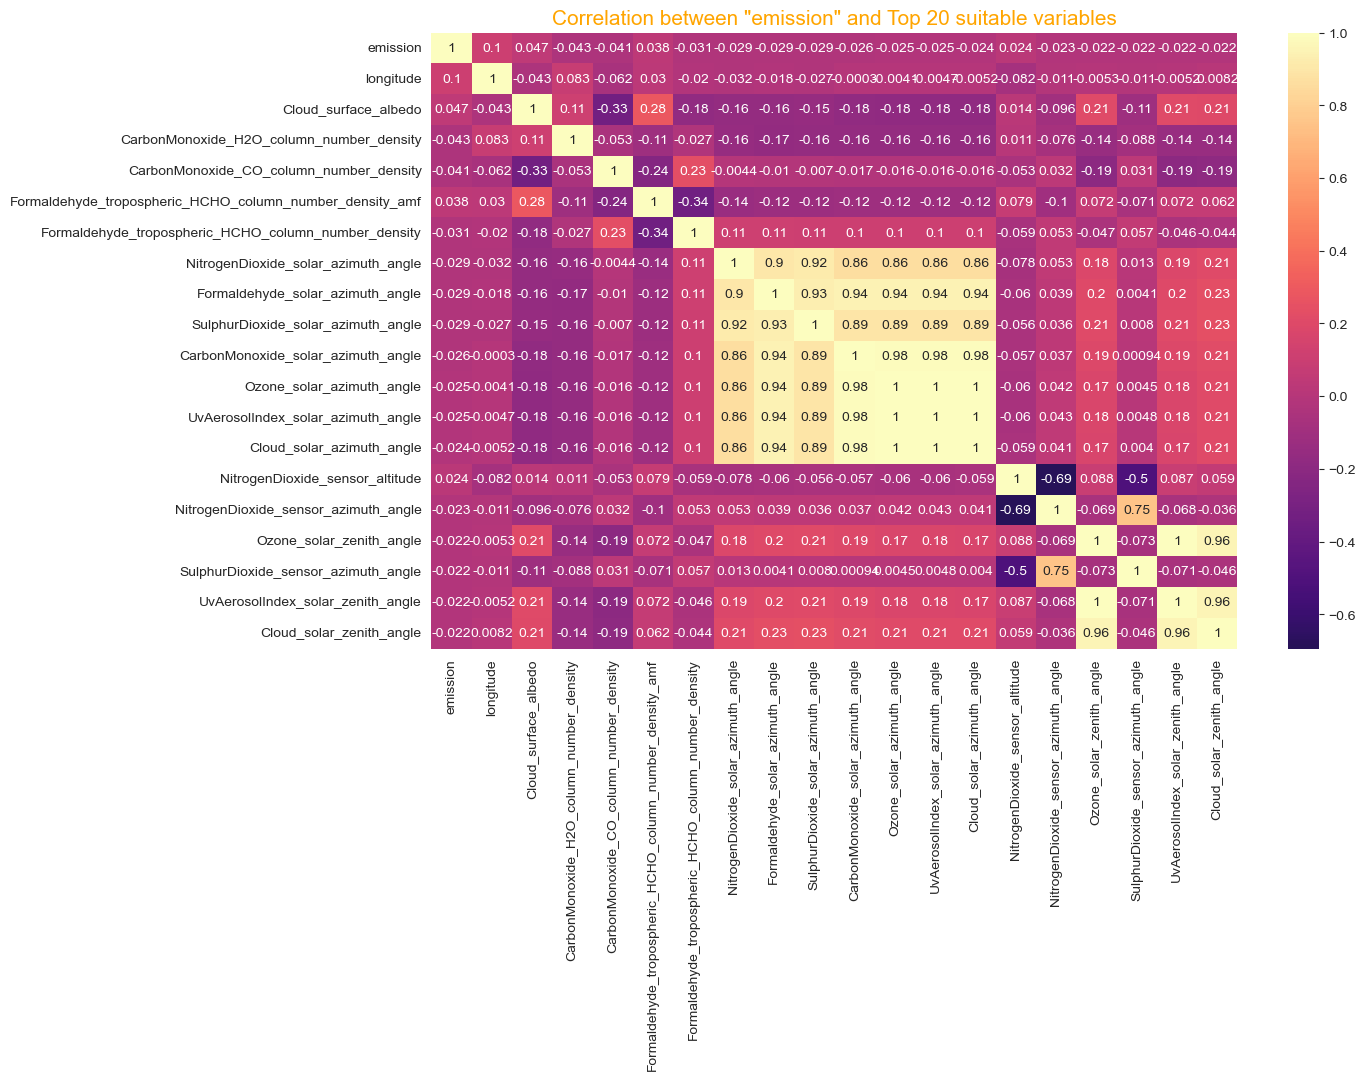

In [26]:
# Quantifying correlations between features
corr = df[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='magma', annot = True, center = 0)
plt.title('Correlation between "emission" and Top 20 suitable variables', fontsize = 15, color = 'orange')
plt.show()

This part of the feature engineering shows that there are many features that is correlated with the target variable `emission`. From the heatmap we can see that `longitude` feature has the highest relation with the target. One can understand from this that he should use the top 20 most correlated variables for the prediction, but I think this is a bad idea.

The satellite measurements is not effective due to significant noise and lack of relevance to the target variable. The measurements are specific to a single point in time, whereas the targets represent the weekly `CO2` emissions. The timing of the measurement is constrained by the satellite's orbit and is influenced by various factors such as clouds, temperature, and volcanic activity. Additionally, CO2 emissions stem from diverse sectors, including ground traffic, heating, power generation, and air traffic, with each sector contributing unevenly to `NO2`, `CO`, or `SO2` levels. Moreover, given Rwanda's small size with a diameter of 200 km, the wind replaces the entire atmosphere of Rwanda with air from neighboring countries on a daily basis.

Moreover, the pattern that we have seen before is a significant indication that we can predict the emission using the variables related to time such as `year`, `week_no`. We should also use `latitude` and `logitude` for two reasons - One is that `logitude` is the highly correlated to the target and second is that it is logical to use these features.

We have already create a `date` column which will really help us in the prediction. Also we already have discarded all the columns that belong to "UvAerosolLayerHeight" group because they all have 99% missing values. Now we have to deal with the entries that were taken in 2020 because we have seen weird pattern in the second quarter of that year.

In [27]:
# Calculating the average monthly emissions for non-virus years (2019 and 2021)
avg_emission_non_virus = df[df['year'].isin((2019,2021))].groupby('week_no')['emission'].mean()

# Calculating the average monthly emissions for virus year (2020)
avg_emission_virus = df[df['year'] == 2020].groupby('week_no')['emission'].mean()

# Calculating the ratios for each month
ratios_for_weeks = avg_emission_non_virus/avg_emission_virus

# Multiplying the emission column for each row in 2020 by the corresponding ratio for the week of that row
df.loc[df['year'] == 2020, 'emission'] *= df['week_no'].map(ratios_for_weeks)

Now let's see if we have succeeded to solve the weird pattern in the year 2020.

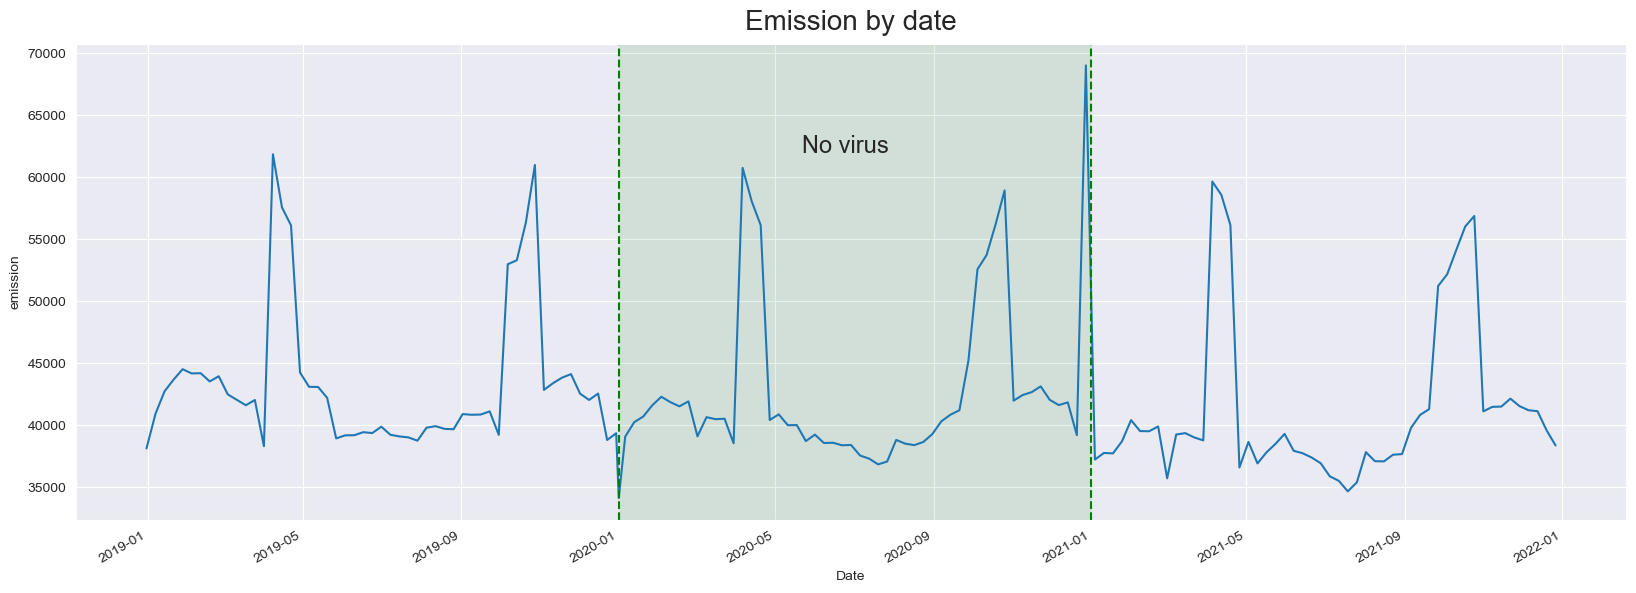

In [28]:
# plotting the same plot with rectified patterns
df.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date', ylabel = 'emission')

plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='green', alpha=0.1)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2021-01-01'), linestyle = "--", color='green')

plt.text(pd.Timestamp('2020-05-22'), 62000, "No virus", size = 17)

plt.title('Emission by date', size=20, pad=10)
plt.show()

It is difficult to notice but we have an outlier at the last week of 2020. We must deal with it.

In [29]:
# dealing with the outlier
df.loc[(df['week_no'] == 52) & (df['year'] == 2020), 'emission'] = np.power(df.loc[(df['week_no'] == 52) & (df['year'] == 2020), 'emission'], 1/1.5)

As the entries are cyclic in nature i.e. taken every week in the year 2019 to 2021, it may be useful to use cyclic features as the variables to improve our model. To understand better, let's look at the plot below.

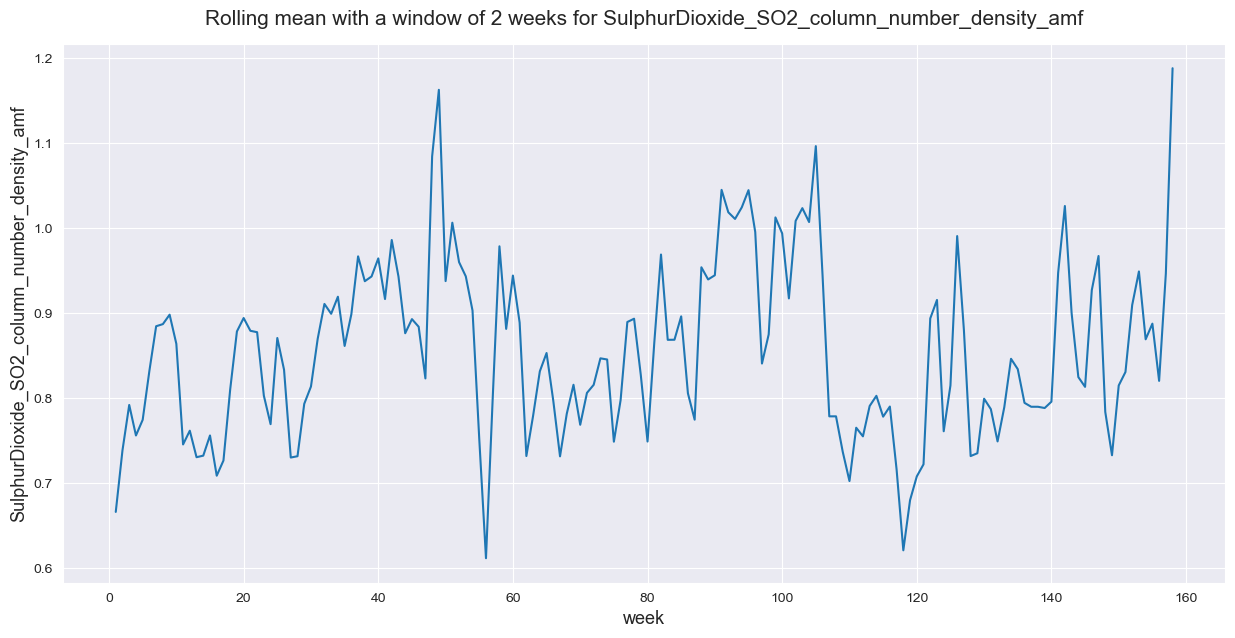

In [30]:
# Lets explore the rolling mean
# First we create a unique location from latitude and longitude
df['location'] = [str(x) + '_' + str(y) for x, y in zip(df.latitude, df.longitude)]

# Filtering based on one location
example_loc = df[df.location == '-0.51_29.29']

# Calculatting rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualising rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y = 1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

The plot above shows how the entries for one variable were taken. We can see a pattern i.e. cyclical that shows us that our data has cyclically measured data. Therefore, emmissions have a cyclic pattern - This will be helpful to our model. With more research and domain knowledge generate useful features that can improve your model performance.

In all the cases, but `year`, the features should be split into two parts: sinus and cosine, to reflect cyclicity, e.g. the 1st January is near the 31st December.

In [31]:
# creating cyclic feature for week_no column
df['week_sin'] = np.sin(2 * np.pi * df['week_no']/53)
df['week_cos'] = np.cos(2 * np.pi * df['week_no']/53)

We should also use rotating location features because the map that we have generated before showed us some useful patterns.

In [32]:
df['rot_15_x'] = (np.cos(np.radians(15)) * df['longitude']) + (np.sin(np.radians(15)) * df['latitude'])

df['rot_15_y'] = (np.cos(np.radians(15)) * df['latitude']) + (np.sin(np.radians(15)) * df['longitude'])

df['rot_30_x'] = (np.cos(np.radians(30)) * df['longitude']) + (np.sin(np.radians(30)) * df['latitude'])

df['rot_30_y'] = (np.cos(np.radians(30)) * df['latitude']) + (np.sin(np.radians(30)) * df['longitude'])

Clustering is also a great feature engineering method that can enhance the model performance. Grouping locations into clusters based on similarities can create categorical features that capture regional characteristics.

The code below utilizes K-Means clustering to group locations based on average emissions and then enriches the training dataset with information about the assigned cluster and the distance of each location to its cluster's center. This additional information can be used as features for training machine learning models, providing insights into the spatial relationships between emissions and locations.

In [33]:
avg_emissions_for_location = df.groupby(['latitude', 'longitude'], as_index=False)['emission'].mean()

cluster_num = 7
kmeans = KMeans(cluster_num, n_init=10,random_state=SEED).fit(avg_emissions_for_location)

# Each of 7 centers has 3 coordinates to describe it - latitude, longitude and emission.
# But we only need latitude and longitude to calculate distance.
centers = kmeans.cluster_centers_[:, :2]

# Getting numpy array where i-th element is a cluster number for i-th location in our DataFrame
clusters = kmeans.predict(avg_emissions_for_location)

# For each location adding cluster and its center coordinates 
avg_emissions_for_location["cluster"] = clusters
avg_emissions_for_location[["latitude_cluster", "longitude_cluster"]] = centers[clusters]

# Calculating distance from location to its cluster's center
highest_emission_location = avg_emissions_for_location.loc[avg_emissions_for_location['emission'].idxmax()]

# avg_emissions_for_location['distance_to_max_emission'] = avg_emissions_for_location.apply(
#     lambda x: haversine(
#         (float(x['latitude']), float(x['longitude'])),
#         (float(highest_emission_location['latitude']),
#          float(highest_emission_location['longitude']))),
#     axis=1
# )

avg_emissions_for_location['distance_to_max_emission'] = avg_emissions_for_location.apply(
    lambda x: haversine(
        (float(x['latitude']), float(x['longitude'])),
        (float(highest_emission_location['latitude']),
         float(highest_emission_location['longitude']))),
    axis=1
)


# Each emission reading (row) from training set will now have its cluster and distance to cluster's center
# Clusters range from [0, 8]
df = df.merge(
    avg_emissions_for_location[['latitude', 'longitude', 'cluster', 'distance_to_max_emission']],
    on=['latitude', 'longitude'],
).set_index(df.index)

Moving forward, we will utilize only a limited subset of features. It has been observed that the model performs optimally when using a select few features derived from the indexing ones, as additional columns tend to introduce unwanted noise. Therefore, there was no necessity to exclude the Uv Aerosol feature group, as we are manually selecting the specific features we intend to incorporate.

We would also like to use `holidays` feature because it may provide more flexibility to our model.

In [34]:
df['holidays'] = (df['week_no'].isin([0, 51, 12, 30]))

In [35]:
training_cols = ['latitude', 'longitude', 'year', 'week_sin', 'week_cos', 'holidays', 'rot_15_x', 'rot_15_y',
                 'rot_30_x', 'rot_30_y', 'distance_to_max_emission']

## 6. Preprocessing

In this section we will split the train data into target and non-target features.

In [36]:
X_train = df.drop(columns='emission')
y_train = df['emission']

And then for smooth and simpler processes, we will apply pipeline method. `make_pipeline` is than normal `Pipeline`, that is why it is being used here. Also `QuantileTransfromer` will change distribution of each feature to match the normal distribution which is prefered by ML models not only that but it will help to lessen the impact of outliers on our model.

In [37]:
# making a pipeline
pipeline = make_pipeline(
SimpleImputer(strategy='mean'),
QuantileTransformer(output_distribution='normal', random_state=SEED), # normalizes columns
StandardScaler(),
)

In [38]:
# fitting the train data with desired columns
X_train = pipeline.fit_transform(X_train[training_cols])

Now let's see our new dataframe looks like.

In [39]:
feature_names = []
for name, transformer in pipeline[1:2].named_steps.items():
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out())

# Use the feature names to create the DataFrame
X_train = pd.DataFrame(X_train, columns=feature_names, index=df.index)
X_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,5.042486,-0.621668,-1.224745,-1.380254e-12,3.527511,3.500000,-0.25854,1.659345,0.171226,1.014999,0.981927
1,5.042486,-0.621668,-1.224745,7.045284e-02,1.163988,-0.285714,-0.25854,1.659345,0.171226,1.014999,0.981927
2,5.042486,-0.621668,-1.224745,1.424934e-01,1.003941,-0.285714,-0.25854,1.659345,0.171226,1.014999,0.981927
3,5.042486,-0.621668,-1.224745,2.158849e-01,0.885287,-0.285714,-0.25854,1.659345,0.171226,1.014999,0.981927
4,5.042486,-0.621668,-1.224745,2.894000e-01,0.762388,-0.285714,-0.25854,1.659345,0.171226,1.014999,0.981927


## 7. Model Selection and Implementation

Here we are using three ML models namely `Linear Regression`, `Random Forest`, and `Gradient Boosting`. We would like to compare the performance of each model using a scoring method called "Mean Squared Error".

In [40]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=SEED),
    'Gradient Boosting': GradientBoostingRegressor(random_state=SEED)
}

results = {}

for model_name, model in models.items():
    
    # Training the model and making predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    
    # Evaluating model performance 
    mse = mean_squared_error(y_train, y_pred)
    
    # Storing the results
    results[model_name] = mse

# Printing the results
for model_name, mse in results.items():
    print(f'{model_name}: Mean Squared Error --> {mse:.2f}')

Linear Regression: Mean Squared Error --> 17498.25
Random Forest: Mean Squared Error --> 46.14
Gradient Boosting: Mean Squared Error --> 4203.42


## 8. Hyperparameter Tuning

In [42]:
param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 4]
        }

# Creating GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=SEED), param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3)

# Fitting the grid search to the data
grid_search.fit(X_train, y_train)

# Getting the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Making predictions on the test set using the best model
y_pred_best = best_model.predict(X_train)

# Evaluating the best model's performance
mse_best = mean_squared_error(y_train, y_pred_best)

print(f'Model: Random Forest')
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error for Best Model: {mse_best:.2f}')

Model: Random Forest
Best Hyperparameters: {'max_depth': 20, 'n_estimators': 100}
Mean Squared Error for Best Model: 84.76


After trying to tune some parameters it is evident that the score became worse. If we try to include more parameters it takes too much time to produce results. So, I think it is good not to do tuning and proceed with the previous random regressor result.

## 9. Submission

At last, it is time for submissoin. But before we submit we need to do the same pre-processing for the test set.

In [47]:
# Accessing the test dataset
df_test = pd.read_csv(r'C:\MY FILES\Kaggle\co2_emission\test.csv')

# Creating Date feature
df_test['date'] = pd.to_datetime(df_test['year'].astype(str) + '-' + df_test['week_no'].astype(str) + '-1', format='%Y-%W-%w')

# Dropping Uv Aerosol related features
df_test.drop(columns=['UvAerosolLayerHeight_aerosol_pressure', 'UvAerosolLayerHeight_solar_zenith_angle',
                   'UvAerosolLayerHeight_aerosol_height', 'UvAerosolLayerHeight_aerosol_optical_depth',
                   'UvAerosolLayerHeight_sensor_zenith_angle', 'UvAerosolLayerHeight_sensor_azimuth_angle',
                   'UvAerosolLayerHeight_solar_azimuth_angle'], inplace=True)

# Creating Cyclic features
df_test['week_sin'] = np.sin(2 * np.pi * df_test['week_no']/53)
df_test['week_cos'] = np.cos(2 * np.pi * df_test['week_no']/53)

# Creating Holidays feature
df_test['holidays'] = (df_test['week_no'].isin([0, 51, 12, 30]))

# Creating Rotating location features
df_test['rot_15_x'] = (np.cos(np.radians(15)) * df_test['longitude']) + (np.sin(np.radians(15)) * df_test['latitude'])
df_test['rot_15_y'] = (np.cos(np.radians(15)) * df_test['latitude']) + (np.sin(np.radians(15)) * df_test['longitude'])
df_test['rot_30_x'] = (np.cos(np.radians(30)) * df_test['longitude']) + (np.sin(np.radians(30)) * df_test['latitude'])
df_test['rot_30_y'] = (np.cos(np.radians(30)) * df_test['latitude']) + (np.sin(np.radians(30)) * df_test['longitude'])

# Creating Cluster features
df_test = df_test.merge(
    avg_emissions_for_location[['latitude', 'longitude', 'cluster', 'distance_to_max_emission']],
    on=['latitude', 'longitude'],
).set_index(df_test.index)

# Preprocessing

feature_names = []
for name, transformer in pipeline[1:2].named_steps.items():
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out())
        
X_test = pd.DataFrame(data=pipeline.transform(df_test[training_cols]), columns=feature_names, index=df_test.index)

After preparing our test dataset it is time to fit and predict the test dataset with `RandomForestRegressor` model.

In [51]:
model = RandomForestRegressor(random_state=SEED)
model.fit(X_train, y_train)
emission_pred = model.predict(X_test)

Then replace the `emission` column with our own prediction column `emission_pred`.

In [52]:
sample_submission['emission'] = emission_pred

Finally create a csv file named as `submission` and submit the file. But unfortunately I can't submit the file because the last date of submission was four months ago. But I had fun doing all the data science stuffs and I hope I did pretty good at it.

In [56]:
sample_submission.to_csv(r'C:\MY FILES\Kaggle\co2_emission\submission.csv')

## Final Thoughts

This project is actually based on a Supervised Machine Learning problem, Regression problem specifically, where I have to create a model predicting the emissions of CO2 emission. Anyone could have thought that `Linear Regression` model can be the best choice but the scores said something different.

My take on this is that no model is perfect for these type of predictions. There could be any number of models good for this project, but eventually I have to chose one of them. Moreover, data pre-processing and analysis are the key here. Without these steps, my model would've done worse. Machine Learning or in broad term Data Science is actually based on two terms, **Handling Data** and **Building Best Model**. My plan for the future is to be better in these two fields.